## 5d. Test the hypothesis that theta sequences extending towards the end decreases the possibility the animal will do the transition again soon.


In [230]:
%reload_ext autoreload
%autoreload 2

In [223]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

In [224]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,categorized_replay_transitions,behavior_transitions,behavior_transitions_count,findXCorrAllDays
from spyglass.shijiegu.decodeHelpers import runSessionNames

In [225]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map,TrialChoiceChangeOfMind
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal,
            find_statescrripts)
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,find_triggered_transition_animal,
    find_triggered_log_session, find_triggered_log_animal,fitLM,labels,seq1,seq2,rev1,rev2,rev3)

In [226]:
import statsmodels.api as sm
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,
    plot_physical_vs_mental_position, parse_to_transitions, 
    find_large_position_minus_decode_trials, normalize_to_1, matrix_correlation,
    find_behavior_sum, find_transitions_sum, find_transitions, correlate_transition_deltabehavior,trials_date_session_to_dict
)
from spyglass.shijiegu.pairwiseDecode import behavior_transitions_count

In [425]:
animal = 'eliot'
dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

In [472]:
animal = 'lewis'

dates_to_plot = ['20240105','20240106','20240107','20240108','20240109',
                 '20240110']#'20240114']#'20240115','20240116','20240117','20240118','20240119','20240120']

#dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

In [456]:
animal = 'lewis'
dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

In [489]:
replay_trials = {}
replay_trials_non = {}

replay_trials[animal] = {}
replay_trials_non[animal] = {}

proportion = 0.05

for d in dates_to_plot:
    (triggered_positions, triggered_positions_abs) = ({}, {})
    (triggered_decodes, triggered_decodes_baseoff, triggered_decodes_abs) = ({}, {}, {})
    triggered_trial_info = {}

    (triggered_positions[animal], triggered_positions_abs[animal],
     triggered_decodes[animal], triggered_decodes_baseoff[animal], triggered_decodes_abs[animal],
     triggered_trial_info[animal]) = find_triggered_animal(animal,[d], proportion = proportion,
                                                           delta_t_minus = 0,delta_t_plus = 2,
                                                           max_flag = 0, segment_only = True)

    (triggered_positions_nb, triggered_positions_abs_nb) = ({}, {})
    (triggered_decodes_nb, triggered_decodes_baseoff_nb, triggered_decodes_abs_nb) = ({}, {}, {})
    
    (triggered_positions_nb[animal], triggered_positions_abs_nb[animal],
     triggered_decodes_nb[animal], triggered_decodes_baseoff_nb[animal], triggered_decodes_abs_nb[animal],
     _) = find_triggered_animal(animal,[d], proportion = proportion,
                                nearby = 1, 
                                delta_t_minus = 2,delta_t_plus = 0.5,
                                max_flag = 0, segment_only = True)


    
    replay_trials[animal][d], inds, _, replay_trials_non[animal][d], inds_non, _  = find_large_position_minus_decode_trials(
        # with theta                # without theta
            animal, triggered_trial_info, 
            triggered_positions_abs, triggered_decodes_baseoff, triggered_positions_abs_nb, triggered_decodes_baseoff_nb)
    


[11:49:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704480077.9866586], [1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923, 1704481045.5162916], [1704481138.1982565, 1704481142.322255], [1704481412.1721525, 1704481413.924152], [1704481446.2081397], [1704481545.218102, 1704481547.6661012, 1704481549.0541005], [1704481570.1540926, 1704481573.2140915], [1704481679.368051, 1704481685.046049, 1704481691.3660467], [1704481736.5840294], [1704482025.24792, 1704482026.8799193], [1704482239.7578387], [1704482412.3897731, 1704482415.369772, 1704482419.2877705], [1704482507.891737, 1704482509.7697363], [1704482585.7997074]]

 turnaround_times 2 [[1704480077.9866586], [1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923, 1704481045.5162916], [1704481138.1982565, 1704481142.322255

[11:49:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704485149.818118], [1704485177.5301104], [1704485230.6240952], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486364.4637747], [1704486628.9276998], [1704486866.8196325], [1704486897.265624], [1704487004.9255936, 1704487007.129593, 1704487007.7835927, 1704487008.3155925, 1704487011.8655915]]

 turnaround_times 2 [[1704485149.818118], [1704485177.5301104], [1704485230.6240952], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486364.4637747], [1704486628.9276998], [1704486866.8196325

[11:49:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489549.3832355], [1704489597.7852242], [1704489649.659212, 1704489655.9832106], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632, 1704489859.3091629, 1704489860.6971626, 1704489862.7791622, 1704489865.0631616], [1704489895.7951543], [1704489925.0551476, 1704489925.7931473, 1704489926.6471472], [1704490090.5511088], [1704490206.9030817], [1704490257.2670698, 1704490258.0010695], [1704490365.0910447], [1704490392.0670383, 1704490393.703038], [1704490573.8849957, 1704490577.1929948], [1704490926.7069132, 1704490928.5829127]]

 turnaround_times 2 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [17044894

[11:49:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]

 turnaround_times 2 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]


[11:49:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[11:49:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704497005.5527592]]

 turnaround_times 2 [[1704497005.5527592]]
currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704480077.9866586], [1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923, 1704481045.5162916], [1704481138.1982565, 1704481142.322255], [1704481412.1721525, 1704481413.924152], [1704481446.2081397], [1704481545.218102, 1704481547.6661012, 1704481549.0541005], [1704481570.1540926, 1704481573.2140915], [1704481679.368051, 1704481685.046049, 1704481691.3660467], [1704481736.5840294], [1704482025.24792, 1704482026.8799193], [1704482239.7578387], [1704482412.3897731, 1704482415.369772, 1704482419.2877705], [1704482507.891737, 1704482509.7697363], [1704482585.7997074]]

 turnaround_times 2 [[1704480077.9866586], [1704480410.9305322], [1704480438.7225218], [1704480548.30448

[11:49:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704485149.818118], [1704485177.5301104], [1704485230.6240952], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486364.4637747], [1704486628.9276998], [1704486866.8196325], [1704486897.265624], [1704487004.9255936, 1704487007.129593, 1704487007.7835927, 1704487008.3155925, 1704487011.8655915]]

 turnaround_times 2 [[1704485149.818118], [1704485177.5301104], [1704485230.6240952], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486364.4637747], [1704486628.9276998], [1704486866.8196325

[11:49:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489549.3832355], [1704489597.7852242], [1704489649.659212, 1704489655.9832106], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632, 1704489859.3091629, 1704489860.6971626, 1704489862.7791622, 1704489865.0631616], [1704489895.7951543], [1704489925.0551476, 1704489925.7931473, 1704489926.6471472], [1704490090.5511088], [1704490206.9030817], [1704490257.2670698, 1704490258.0010695], [1704490365.0910447], [1704490392.0670383, 1704490393.703038], [1704490573.8849957, 1704490577.1929948], [1704490926.7069132, 1704490928.5829127]]

 turnaround_times 2 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [17044894

[11:49:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]

 turnaround_times 2 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]


[11:49:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704497005.5527592]]

 turnaround_times 2 [[1704497005.5527592]]


[11:49:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704564749.4928849, 1704564751.2888842], [1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565371.0205984], [1704565557.8145125, 1704565560.8765109], [1704565624.2164817], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]

 turnaround_times 2 [[1704564749.4928849, 1704564751.2888842], [1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565371.0205984], [1704565557.8145125, 1704565560.8765109], [1704565624.2164817], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]


[11:49:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569549.9332736], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]

 turnaround_times 2 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569549.9332736], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]
some missing position data
some missing position data


[11:49:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704573705.5670273], [1704573731.1150227], [1704573820.371006], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]

 turnaround_times 2 [[1704573705.5670273], [1704573731.1150227], [1704573820.371006], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]


[11:49:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]

 turnaround_times 2 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]


[11:49:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704564749.4928849, 1704564751.2888842], [1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565371.0205984], [1704565557.8145125, 1704565560.8765109], [1704565624.2164817], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]

 turnaround_times 2 [[1704564749.4928849, 1704564751.2888842], [1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565371.0205984], [1704565557.8145125, 1704565560.8765109], [1704565624.2164817], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]


[11:49:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569549.9332736], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]

 turnaround_times 2 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569549.9332736], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]


[11:49:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704573705.5670273], [1704573731.1150227], [1704573820.371006], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]

 turnaround_times 2 [[1704573705.5670273], [1704573731.1150227], [1704573820.371006], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]


[11:50:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]

 turnaround_times 2 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]


[11:50:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833], [1704661443.8948252], [1704661570.4127877]]

 turnaround_times 2 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833], [1704661443.8948252], [1704661570.4127877]]


[11:50:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]

 turnaround_times 2 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]


[11:50:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]

 turnaround_times 2 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]


[11:50:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673389.971801], [1704673516.081683], [1704673581.4636216]]

 turnaround_times 2 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673389.971801], [1704673516.081683], [1704673581.4636216]]


[11:50:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]

 turnaround_times 2 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]


[11:50:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833], [1704661443.8948252], [1704661570.4127877]]

 turnaround_times 2 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833], [1704661443.8948252], [1704661570.4127877]]


[11:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]

 turnaround_times 2 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]


[11:50:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]

 turnaround_times 2 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]


[11:50:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673389.971801], [1704673516.081683], [1704673581.4636216]]

 turnaround_times 2 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673389.971801], [1704673516.081683], [1704673581.4636216]]


[11:50:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]

 turnaround_times 2 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]


[11:50:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704749571.595262], [1704749886.049168], [1704750426.8930063], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751180.3207808], [1704751231.1747656]]

 turnaround_times 2 [[1704749571.595262], [1704749886.049168], [1704750426.8930063], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751180.3207808], [1704751231.1747656]]


[11:50:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704753803.4757729], [1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567, 1704755236.8726518], [1704755275.3606217], [1704755468.5624707], [1704755594.714372], [1704755636.6283393], [1704755664.5843174]]

 turnaround_times 2 [[1704753803.4757729], [1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [170

[11:50:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664], [1704758896.5971494]]

 turnaround_times 2 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664], [1704758896.5971494]]


[11:50:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761872.0902631], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]

 turnaround_times 2 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761872.0902631], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]


[11:50:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704749571.595262], [1704749886.049168], [1704750426.8930063], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751180.3207808], [1704751231.1747656]]

 turnaround_times 2 [[1704749571.595262], [1704749886.049168], [1704750426.8930063], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751180.3207808], [1704751231.1747656]]


[11:50:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704753803.4757729], [1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567, 1704755236.8726518], [1704755275.3606217], [1704755468.5624707], [1704755594.714372], [1704755636.6283393], [1704755664.5843174]]

 turnaround_times 2 [[1704753803.4757729], [1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [170

[11:50:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664], [1704758896.5971494]]

 turnaround_times 2 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664], [1704758896.5971494]]


[11:50:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761872.0902631], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]

 turnaround_times 2 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761872.0902631], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]


[11:51:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828106.9705527], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828106.9705527], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]


[11:51:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832757.604297, 1704832758.9922957], [1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833502.339726], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832757.604297, 1704832758.9922957], [1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833502.339726], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.60929

[11:51:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]
some missing position data


[11:51:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842146.0230346], [1704842208.1789973], [1704842240.666978], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842146.0230346], [1704842208.1789973], [1704842240.666978], [1704842384.7308917]]


[11:51:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828106.9705527], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828106.9705527], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]


[11:51:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832757.604297, 1704832758.9922957], [1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833502.339726], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832757.604297, 1704832758.9922957], [1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833502.339726], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.60929

[11:51:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]


[11:51:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842146.0230346], [1704842208.1789973], [1704842240.666978], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842146.0230346], [1704842208.1789973], [1704842240.666978], [1704842384.7308917]]


[11:51:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704911987.9633172], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [1704912829.4247198, 1704912831.5467184], [1704913146.9024944, 1704913152.0024908]]

 turnaround_times 2 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704911987.9633172], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [17049128

[11:51:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916298.3109863], [1704916412.9529603], [1704916653.906906, 1704916656.0009053, 1704916657.0489051, 1704916661.906904], [1704916717.4908915], [1704916855.1908603], [1704916992.686829], [1704917043.0908177], [1704917175.646788, 1704917176.5067875], [1704917207.5207806], [1704917411.0907345]]

 turnaround_times 2 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916298.3109863], [170

[11:51:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]

 turnaround_times 2 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]


[11:51:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704924774.255382], [1704924807.2333493]]

 turnaround_times 2 [[1704924774.255382], [1704924807.2333493]]


[11:51:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]

 turnaround_times 2 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]


[11:51:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704911987.9633172], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [1704912829.4247198, 1704912831.5467184], [1704913146.9024944, 1704913152.0024908]]

 turnaround_times 2 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704911987.9633172], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [17049128

[11:51:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916298.3109863], [1704916412.9529603], [1704916653.906906, 1704916656.0009053, 1704916657.0489051, 1704916661.906904], [1704916717.4908915], [1704916855.1908603], [1704916992.686829], [1704917043.0908177], [1704917175.646788, 1704917176.5067875], [1704917207.5207806], [1704917411.0907345]]

 turnaround_times 2 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916298.3109863], [1704916412.9529603], [17049166

[11:51:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]

 turnaround_times 2 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]


[11:51:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704924774.255382], [1704924807.2333493]]

 turnaround_times 2 [[1704924774.255382], [1704924807.2333493]]


[11:51:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]

 turnaround_times 2 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]


In [490]:
from spyglass.shijiegu.changeOfMind_deltat import find_delta_t
from scipy.stats import ranksums

from scipy.stats import permutation_test
from scipy.stats import mode
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [491]:
log_df[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,change_of_mind,CoMMaxProportion,CoM_t,CoM_arm,current,future_H,future_O,past,past_reward
1,1.666828e+09,1.0,1.666828e+09,3.0,2.0,False,[],[],[],3.0,3.0,4.0,NaN,NaN
2,1.666828e+09,1.0,1.666828e+09,4.0,2.0,False,[],[],[],4.0,4.0,2.0,3.0,3.0
3,1.666828e+09,1.0,1.666828e+09,2.0,2.0,False,[],[],[],2.0,2.0,1.0,4.0,4.0
4,1.666828e+09,1.0,1.666828e+09,1.0,2.0,False,[],[],[],1.0,1.0,3.0,2.0,2.0
5,1.666828e+09,1.0,1.666828e+09,3.0,2.0,False,[],[],[],3.0,3.0,4.0,1.0,1.0
6,1.666828e+09,1.0,1.666828e+09,4.0,2.0,False,[],[],[],4.0,4.0,2.0,3.0,3.0
7,1.666828e+09,1.0,1.666828e+09,2.0,2.0,False,[],[],[],2.0,2.0,1.0,4.0,4.0
8,1.666828e+09,1.0,1.666828e+09,1.0,2.0,False,[],[],[],1.0,1.0,3.0,2.0,2.0
9,1.666828e+09,1.0,1.666828e+09,3.0,2.0,False,[],[],[],3.0,3.0,4.0,1.0,1.0
10,1.666828e+09,1.0,1.666828e+09,4.0,2.0,False,[],[],[],4.0,4.0,1.0,3.0,3.0


### First, paired comparisons.
Limited data points

In [494]:
paired = True
type = 1

diff_theta_transition_day = {}
diff_nontheta_transition_day = {}

for day in dates_to_plot:
    nwb_file_name = animal.lower() + day + '.nwb'
    nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
    session_interval, position_interval = runSessionNames(nwb_copy_file_name)

    diff_theta_transition_session = []
    diff_nontheta_transition_session = []
    for ind in range(len(session_interval)):
        session_name = session_interval[ind]
        position_name = position_interval[ind]
        diff_theta_transition_session_, diff_nontheta_transition_session_ = find_delta_t(
            nwb_copy_file_name, session_name, proportion, replay_trials, replay_trials_non, paired, type = type) #replay_trials)
        
        diff_theta_transition_session.append(diff_theta_transition_session_)
        diff_nontheta_transition_session.append(diff_nontheta_transition_session_)

    diff_theta_transition_day[day] = diff_theta_transition_session
    diff_nontheta_transition_day[day] = diff_nontheta_transition_session

lewis20240105_.nwb 02_Rev2Session1
trials_long_theta [[20, (2, 3)], [50, (4, 1)], [62, (3, 2)], [66, (1, 2)], [70, (4, 2)], [70, (4, 1)], [71, (3, 1)], [88, (4, 2)], [95, (1, 2)], [98, (3, 1)], [98, (3, 1)]]
trials_short_theta [[5, (3, 4)], [19, (1, 3)], [25, (2, 4)], [31, (2, 3)], [34, (3, 2)], [42, (4, 1)], [46, (4, 2)], [46, (4, 1)], [50, (4, 3)], [61, (1, 3)], [61, (1, 2)], [65, (4, 1)], [65, (4, 3)], [65, (4, 2)], [70, (4, 1)], [80, (3, 1)], [80, (3, 2)], [95, (1, 4)], [95, (1, 1)], [101, (4, 3)]]
transitions [[1 2]
 [2 3]
 [3 1]
 [3 2]
 [4 1]
 [4 2]]
lewis20240105_.nwb 04_Rev2Session2
trials_long_theta [[9, (3, 1)], [16, (4, 1)], [22, (4, 2)], [30, (2, 1)], [81, (4, 1)], [81, (4, 1)], [81, (4, 1)]]
trials_short_theta [[5, (4, 1)], [6, (3, 2)], [8, (2, 4)], [13, (3, 2)], [19, (2, 4)], [26, (4, 1)], [30, (2, 3)], [35, (1, 2)], [40, (4, 2)], [43, (1, 4)], [43, (1, 3)], [57, (1, 3)], [68, (1, 4)], [76, (2, 3)], [77, (4, 1)], [81, (4, 3)], [81, (4, 2)]]
transitions [[2 1]
 [3 1]
 [4 1

[Text(1, 0, 'theta'), Text(2, 0, 'nontheta')]

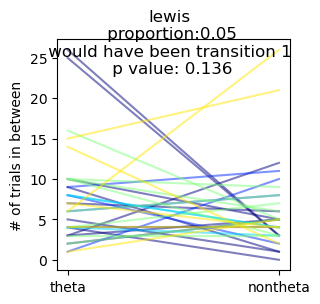

In [495]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(1,1,figsize = (3,3),sharex = True, sharey = True)

d_ind = 0
sample_theta = []
sample_nontheta = []
for d in diff_theta_transition_day.keys():
    diff_theta_day = diff_theta_transition_day[d]
    diff_nontheta_day = diff_nontheta_transition_day[d]

    for diff_theta_ind in range(len(diff_theta_day)):
        diff_theta = diff_theta_day[diff_theta_ind]
        diff_nontheta = diff_nontheta_day[diff_theta_ind]
        
        for transition in diff_theta.keys():
            #axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes.plot([1,2], [diff_theta[transition], diff_nontheta[transition]],
                                   color = cmap(norm(d_ind)), alpha = 0.5)
            for delta_t in diff_theta[transition]:
                sample_theta.append(delta_t)
            for delta_t in diff_nontheta[transition]:
                sample_nontheta.append(delta_t)
    d_ind += 1

res = permutation_test((sample_theta, sample_nontheta), statistic, permutation_type="samples",vectorized=True,
                       n_resamples=10000, alternative='greater')

axes.set_ylabel("# of trials in between")
plt.suptitle(animal + '\n proportion:' +str(proportion) +'\n would have been transition ' + str(type) +' \n p value: '+str(np.round(res.pvalue,3)))  

axes.set_xticks([1,2])
axes.set_ylabel("# of trials in between")
axes.set_xticklabels(["theta","nontheta"])

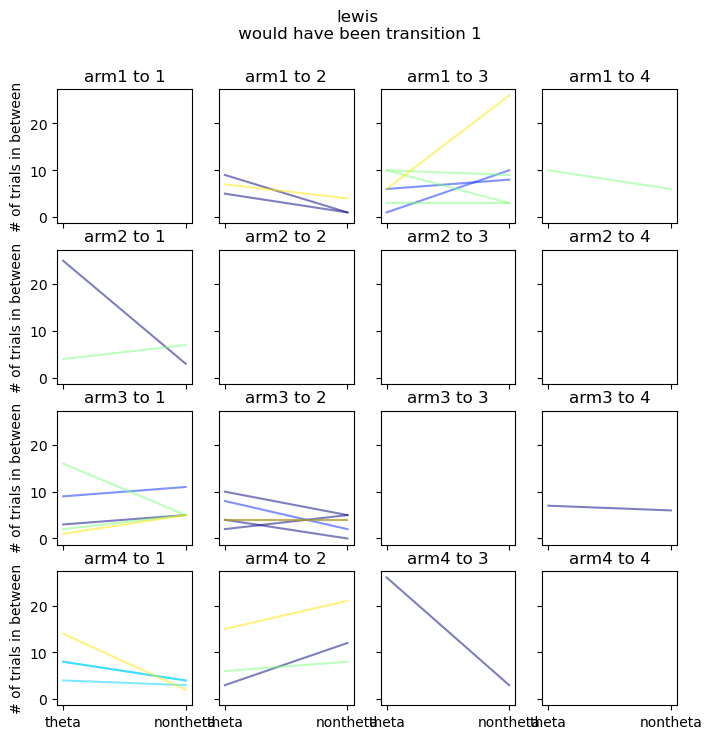

In [496]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

d_ind = 0
for d in diff_theta_transition_day.keys():
    diff_theta_day = diff_theta_transition_day[d]
    diff_nontheta_day = diff_nontheta_transition_day[d]

    for diff_theta_ind in range(len(diff_theta_day)):
        diff_theta = diff_theta_day[diff_theta_ind]
        diff_nontheta = diff_nontheta_day[diff_theta_ind]
        
        for transition in diff_theta.keys():
            axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes[axe_i - 1, axe_j - 1].plot([1,2], [diff_theta[transition], diff_nontheta[transition]],
                                   color = cmap(norm(d_ind)), alpha = 0.5)
    d_ind += 1

plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        axes[axe_i, axe_j].set_xticks([1,2])
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of trials in between")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xticklabels(["theta","nontheta"])
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

### Second, all nontheta

In [497]:
paired = False
type = 1

diff_theta_transition_day = {}
diff_nontheta_transition_day = {}

for day in dates_to_plot:
    nwb_file_name = animal.lower() + day + '.nwb'
    nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
    session_interval, position_interval = runSessionNames(nwb_copy_file_name)

    diff_theta_transition_session = []
    diff_nontheta_transition_session = []
    for ind in range(len(session_interval)):
        session_name = session_interval[ind]
        position_name = position_interval[ind]
        diff_theta_transition_session_, diff_nontheta_transition_session_ = find_delta_t(
            nwb_copy_file_name, session_name, proportion, replay_trials, replay_trials_non, paired, type = type) #replay_trials)
        
        diff_theta_transition_session.append(diff_theta_transition_session_)
        diff_nontheta_transition_session.append(diff_nontheta_transition_session_)

    diff_theta_transition_day[day] = diff_theta_transition_session
    diff_nontheta_transition_day[day] = diff_nontheta_transition_session

lewis20240105_.nwb 02_Rev2Session1
trials_long_theta [[20, (2, 3)], [50, (4, 1)], [62, (3, 2)], [66, (1, 2)], [70, (4, 2)], [70, (4, 1)], [71, (3, 1)], [88, (4, 2)], [95, (1, 2)], [98, (3, 1)], [98, (3, 1)]]
trials_short_theta [[5, (3, 4)], [19, (1, 3)], [25, (2, 4)], [31, (2, 3)], [34, (3, 2)], [42, (4, 1)], [46, (4, 2)], [46, (4, 1)], [50, (4, 3)], [61, (1, 3)], [61, (1, 2)], [65, (4, 1)], [65, (4, 3)], [65, (4, 2)], [70, (4, 1)], [80, (3, 1)], [80, (3, 2)], [95, (1, 4)], [95, (1, 1)], [101, (4, 3)]]
transitions [[1 2]
 [2 3]
 [3 1]
 [3 2]
 [4 1]
 [4 2]]
lewis20240105_.nwb 04_Rev2Session2
trials_long_theta [[9, (3, 1)], [16, (4, 1)], [22, (4, 2)], [30, (2, 1)], [81, (4, 1)], [81, (4, 1)], [81, (4, 1)]]
trials_short_theta [[5, (4, 1)], [6, (3, 2)], [8, (2, 4)], [13, (3, 2)], [19, (2, 4)], [26, (4, 1)], [30, (2, 3)], [35, (1, 2)], [40, (4, 2)], [43, (1, 4)], [43, (1, 3)], [57, (1, 3)], [68, (1, 4)], [76, (2, 3)], [77, (4, 1)], [81, (4, 3)], [81, (4, 2)]]
transitions [[2 1]
 [3 1]
 [4 1

[Text(0, 0, 'theta'), Text(1, 0, 'nontheta')]

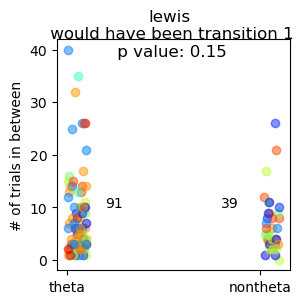

In [498]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(transitions))

fig,axes = plt.subplots(1,1,figsize = (3,3),sharex = True, sharey = True)

sample_theta = []
sample_nontheta = []

d_ind = 0
for d in diff_theta_transition_day.keys():
    diff_theta_day = diff_theta_transition_day[d]
    diff_nontheta_day = diff_nontheta_transition_day[d]

    for diff_theta_ind in range(len(diff_theta_day)):
        diff_theta = diff_theta_day[diff_theta_ind]
        
        for transition in diff_theta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            #axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes.scatter(np.zeros_like(diff_theta[transition]) + np.random.uniform(0,0.1,len(diff_theta[transition])), diff_theta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)
            for delta_t in diff_theta[transition]:
                sample_theta.append(delta_t)

    for diff_nontheta_ind in range(len(diff_nontheta_day)):
        diff_nontheta = diff_nontheta_day[diff_nontheta_ind]
        
        for transition in diff_nontheta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            #axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes.scatter(np.zeros_like(diff_nontheta[transition]) + 1 + np.random.uniform(0,0.1,len(diff_nontheta[transition])), diff_nontheta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)
            for delta_t in diff_nontheta[transition]:
                sample_nontheta.append(delta_t)
            
    d_ind += 1

#statistic, pvalue = ranksums(sample_theta, sample_nontheta, "greater")
res = permutation_test((sample_theta, sample_nontheta), statistic, vectorized=True,
                       n_resamples=10000, alternative='greater')

axes.set_ylabel("# of trials in between")
plt.suptitle(animal + '\n would have been transition ' + str(type) + '\n p value: '+str(np.round(res.pvalue,3)))    

axes.set_xticks([0,1])
axes.text(0.2,10,str(len(sample_theta)))
axes.text(0.8,10,str(len(sample_nontheta)))

axes.set_xticklabels(["theta","nontheta"])

In [499]:
print(f"len(sample_theta): {len(sample_theta)},  len(sample_nontheta):{len(sample_nontheta)}")

len(sample_theta): 91,  len(sample_nontheta):39


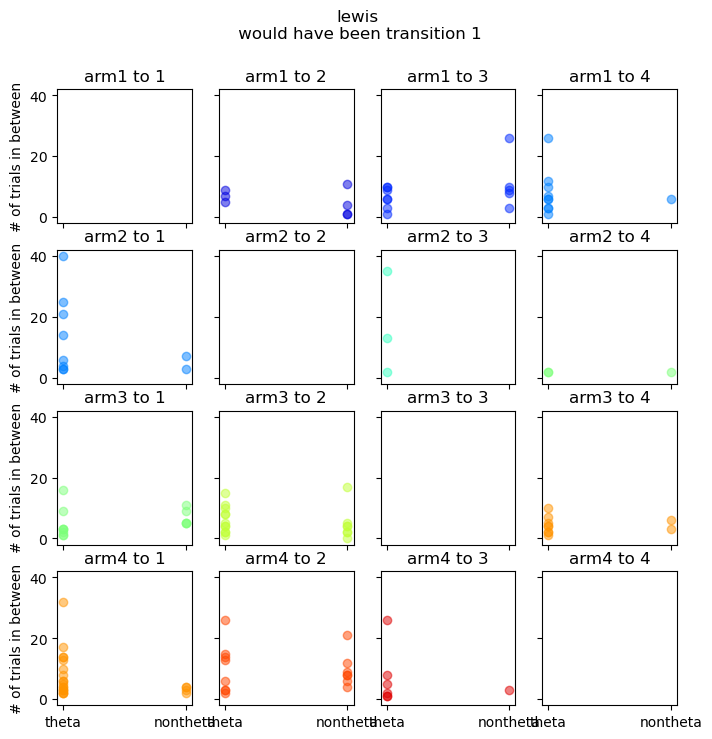

In [500]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(transitions))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

d_ind = 0
for d in diff_theta_transition_day.keys():
    diff_theta_day = diff_theta_transition_day[d]
    diff_nontheta_day = diff_nontheta_transition_day[d]
    
    for diff_theta_ind in range(len(diff_theta_day)):
        diff_theta = diff_theta_day[diff_theta_ind]
        
        for transition in diff_theta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes[axe_i - 1, axe_j - 1].scatter(np.zeros_like(diff_theta[transition]), diff_theta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)

    for diff_nontheta_ind in range(len(diff_nontheta_day)):
        diff_nontheta = diff_nontheta_day[diff_nontheta_ind]
        
        for transition in diff_nontheta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes[axe_i - 1, axe_j - 1].scatter(np.zeros_like(diff_nontheta[transition]) + 1, diff_nontheta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)
    d_ind += 1

plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        axes[axe_i, axe_j].set_xticks([0,1])
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of trials in between")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xticklabels(["theta","nontheta"])
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

In [128]:
replay_trials[animal]['20221019']

[('eliot20221019_.nwb', '02_Seq2Session1', 10, 1),
 ('eliot20221019_.nwb', '02_Seq2Session1', 52, 3),
 ('eliot20221019_.nwb', '02_Seq2Session1', 57, 1),
 ('eliot20221019_.nwb', '02_Seq2Session1', 57, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 16, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 45, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 76, 4),
 ('eliot20221019_.nwb', '04_Seq2Session2', 76, 2),
 ('eliot20221019_.nwb', '04_Seq2Session2', 81, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 81, 3),
 ('eliot20221019_.nwb', '06_Seq2Session3', 8, 3),
 ('eliot20221019_.nwb', '06_Seq2Session3', 15, 3),
 ('eliot20221019_.nwb', '08_Seq2Session4', 25, 1),
 ('eliot20221019_.nwb', '08_Seq2Session4', 33, 3),
 ('eliot20221019_.nwb', '08_Seq2Session4', 34, 1),
 ('eliot20221019_.nwb', '08_Seq2Session4', 37, 1),
 ('eliot20221019_.nwb', '10_Seq2Session5', 26, 2)]

In [60]:
(nwb_copy_file_name, session_name, trial, _ ) = replay_trials[animal]['20221021'][1]

In [159]:
d = '20221019'

nwb_copy_file_name = 'eliot'+ d + '_.nwb'
print(nwb_copy_file_name)
session_name = '02_Seq2Session1'



eliot20221019_.nwb
trials_all_transition [8, 24, 28, 32, 47, 55, 59, 65, 75, 79]
trials_theta_transition [52]
trials_all_transition [3, 7, 12, 16, 33, 38, 44, 72, 80]
trials_theta_transition [10 57]


In [161]:
diff_theta_all

[8, 5, 28]

In [162]:
diff_nontheta_all

[15, 4, 6]

In [141]:
transition

array([3, 1])

In [ ]:
# for a CoM trial, find would have been transition

# find the time before it repeats



In [234]:
animal = 'Lewis'

dates_to_plot = ['20240105','20240106','20240107','20240108','20240109',
                 '20240110']#'20240114']#'20240115','20240116','20240117','20240118','20240119','20240120']

dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

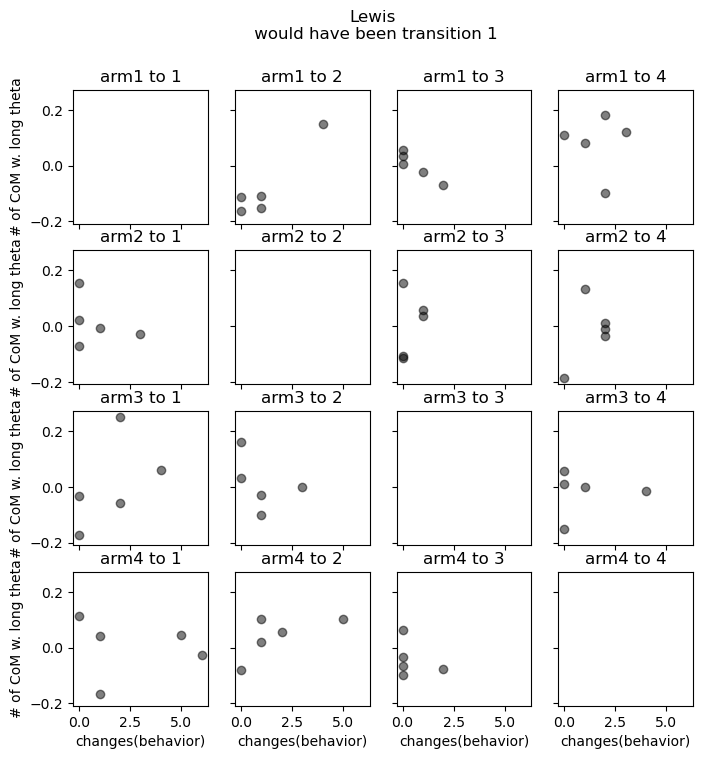

In [244]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# for aggregate plot
T_wouldhave_count1 = []
T_wouldhave_count2 = []
behavior_count = []

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])

    # for lumping across transitions
    behavior_count.append(delta_behavior.ravel())
    T_wouldhave_count1.append(T_wouldhave[list(T_wouldhave.keys())[0]].ravel())
    T_wouldhave_count2.append(T_wouldhave2[list(T_wouldhave2.keys())[0]].ravel())

    # for individual transitions
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave[list(T_wouldhave.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

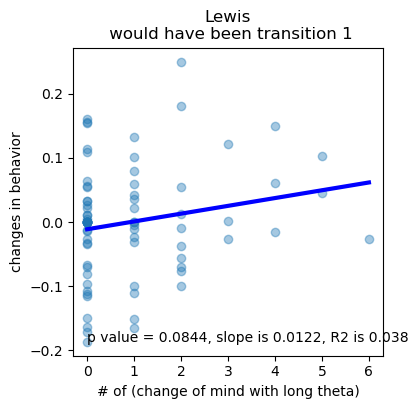

In [240]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')
axes.set_xlabel("# of (change of mind with long theta)")
axes.set_ylabel("changes in behavior")

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

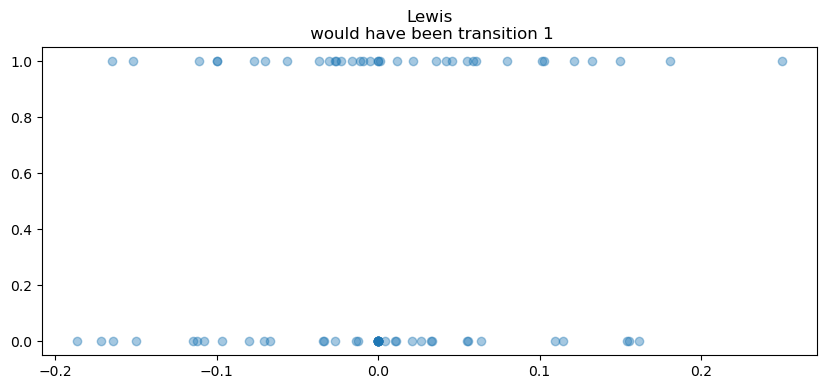

In [238]:
fig,axes = plt.subplots(1,1,figsize = (10,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
#results, pvalue = fitLM(x,y)
    
axes.scatter(y, x > 0, alpha = 0.4)
#x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
#y_plot=results.predict(sm.add_constant(x_plot))
#pvalue_beta = results.pvalues[1]
    
#axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
#axes.text(np.min(x),np.min(y),
#          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

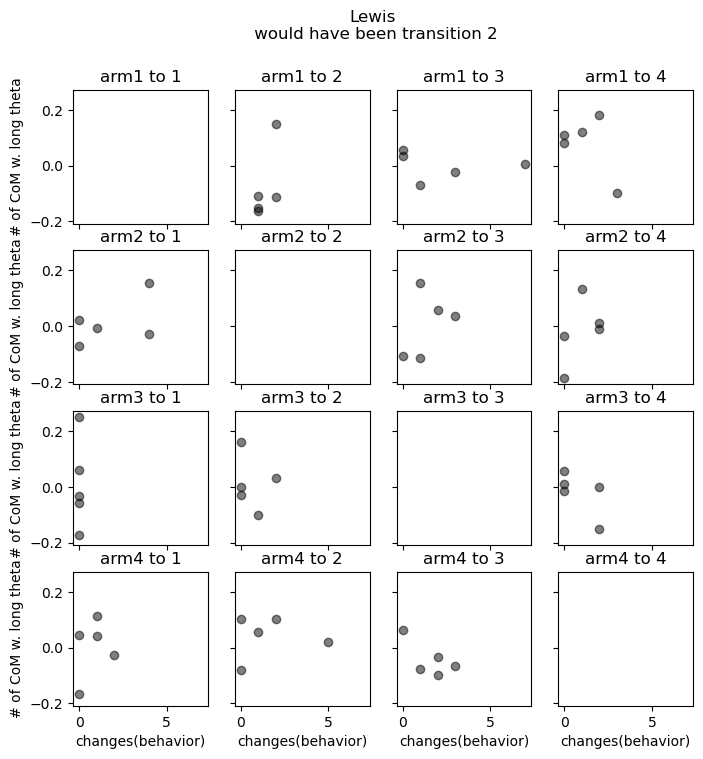

In [245]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave2[list(T_wouldhave2.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
        
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 2')
for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.0, -0.26344086021505375, 'p value = 0.2286, slope is -0.01, R2 is 0.011')

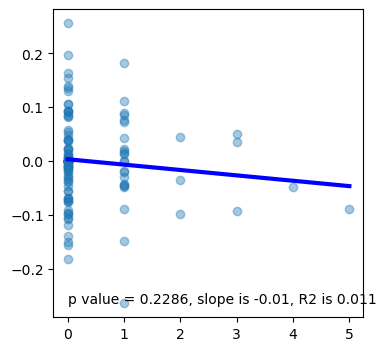

In [233]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count2)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)